# ECGR 4105-001, Homework 5
## By Joshua Foster, 801268119

In [51]:
import torch
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Problem 1

In our temperature prediction example, let’s change our model to a nonlinear system. Consider the following description for our model:



w2 * t_u ** 2 + w1 * t_u + b.

1.a Modify the training loop properly to accommodate this redefinition.

In [52]:
# Data
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

t_un = t_u * .1

# Model
def model_1a(t_u, w1, w2, b):
  return w2 * (t_u**2) + w1 * t_u + b

# Loss
def loss_fn(t_p, t_c):
  squared_diffs = (t_p-t_c)**2
  return squared_diffs.mean()

In [53]:
final_loss = 0.0

def training_loop(n_epochs, optimizer, params, t_u, t_c, model_fn):
  for epoch in range(1, n_epochs+1):
    # Forward
    t_p = model_fn(t_u, *params)

    # Loss
    loss = loss_fn(t_p, t_c)

    # Zero gradients before backward
    optimizer.zero_grad()

    # Backward
    loss.backward()

    # Update params
    optimizer.step()

    if epoch % 500 == 0:
      print(f'Epoch {epoch}, Loss {loss.item():.4f}')

    if epoch == n_epochs:
      final_loss = loss.item()

  print("--- Training Complete ---\n")
  return params, final_loss

1.b Use 5000 epochs for your training. Explore different learning rates from 0.1 to 0.0001 (you need four separate trainings). Report your loss for every 500 epochs per training.

In [54]:
from prompt_toolkit.styles import BaseStyle
learning_rates = [0.1, 0.01, 0.001, 0.0001]
n_epochs = 5000

# best model for 1c
best_loss = float('inf')
best_lr = None
best_params_nonlinear = None

for lr in learning_rates:
  # initialize paramters for each training run
  params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)

  optimizer = optim.Adam([params], lr=lr)

  final_params, final_loss = training_loop(
      n_epochs = n_epochs,
      optimizer = optimizer,
      params = params,
      t_u = t_u,
      t_c = t_c,
      model_fn = model_1a
  )

  if final_loss < best_loss:
    best_loss = final_loss
    best_lr = lr
    best_params_nonlinear = final_params

print(f"\n--- Experiment Summary ---")
print(f"Best non-linear model found with learning rate: {best_lr}")
print(f"Best non-linear final loss: {best_loss:.4f}")
print(f"Best parameters (w2, w1, b): {best_params_nonlinear.data}")

Epoch 500, Loss 4.8445
Epoch 1000, Loss 3.7856
Epoch 1500, Loss 3.4667
Epoch 2000, Loss 3.4064
Epoch 2500, Loss 3.3780
Epoch 3000, Loss 3.3443
Epoch 3500, Loss 3.3019
Epoch 4000, Loss 3.2491
Epoch 4500, Loss 3.1844
Epoch 5000, Loss 3.1064
--- Training Complete ---

Epoch 500, Loss 6.1087
Epoch 1000, Loss 5.9844
Epoch 1500, Loss 5.8090
Epoch 2000, Loss 5.5863
Epoch 2500, Loss 5.3209
Epoch 3000, Loss 5.0213
Epoch 3500, Loss 4.7013
Epoch 4000, Loss 4.3808
Epoch 4500, Loss 4.0834
Epoch 5000, Loss 3.8327
--- Training Complete ---

Epoch 500, Loss 3668163.0000
Epoch 1000, Loss 768786.4375
Epoch 1500, Loss 90021.1250
Epoch 2000, Loss 4791.3398
Epoch 2500, Loss 98.0142
Epoch 3000, Loss 6.6097
Epoch 3500, Loss 6.1173
Epoch 4000, Loss 6.0968
Epoch 4500, Loss 6.0711
Epoch 5000, Loss 6.0384
--- Training Complete ---

Epoch 500, Loss 10577728.0000
Epoch 1000, Loss 9524402.0000
Epoch 1500, Loss 8545122.0000
Epoch 2000, Loss 7634292.5000
Epoch 2500, Loss 6787368.0000
Epoch 3000, Loss 6000706.0000
Epo

1.c Pick the best non-linear model and compare your final best loss against the linear model that we did during the lecture. For this, visualize the non-linear model against the linear model over the input dataset, as we did during the lecture. Is the actual result better or worse than our baseline linear model?

In [55]:
# Linear model from lecture
def model_1c(t_u, w, b):
  return w * t_u + b

# Config
lr_lin = 1e-2
n_epochs_lin = 5000

params_linear = torch.tensor([1.0, 0.0], requires_grad=True)

optimizer_linear = optim.SGD([params_linear], lr=lr_lin)

In [56]:
# Training
params_linear_final, loss_linear_final = training_loop(
    n_epochs = n_epochs_lin,
    optimizer = optimizer_linear,
    params = params_linear,
    t_u = t_un,
    t_c = t_c,
    model_fn = model_1c
)

print(f"\n--- Baseline Summary ---")
print(f"Baseline linear model final loss: {loss_linear_final:.4f}")
print(f"Baseline parameters (w, b): {params_linear_final.data}")

Epoch 500, Loss 7.8601
Epoch 1000, Loss 3.8285
Epoch 1500, Loss 3.0922
Epoch 2000, Loss 2.9577
Epoch 2500, Loss 2.9331
Epoch 3000, Loss 2.9286
Epoch 3500, Loss 2.9278
Epoch 4000, Loss 2.9277
Epoch 4500, Loss 2.9277
Epoch 5000, Loss 2.9276
--- Training Complete ---


--- Baseline Summary ---
Baseline linear model final loss: 2.9276
Baseline parameters (w, b): tensor([  5.3671, -17.3012])


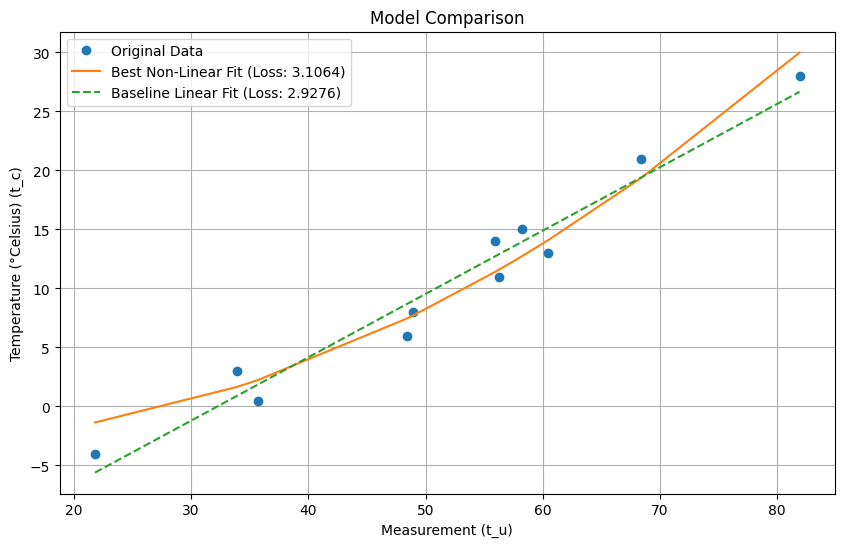

In [57]:
# Visualization

t_u_sorted, indices = torch.sort(t_u)
t_c_sorted = t_c[indices]

with torch.no_grad():
    # Get predictions from the BEST non-linear model
    t_p_nonlinear = model_1a(t_u_sorted, *best_params_nonlinear)

    # Get predictions from the baseline linear model
    t_un_sorted = t_u_sorted * 0.1
    t_p_linear = model_1c(t_un_sorted, *params_linear_final)

# Plot the data and the two models
plt.figure(figsize=(10, 6))
plt.plot(t_u.numpy(), t_c.numpy(), 'o', label='Original Data')
plt.plot(t_u_sorted.numpy(), t_p_nonlinear.numpy(), '-', label=f'Best Non-Linear Fit (Loss: {best_loss:.4f})')
plt.plot(t_u_sorted.numpy(), t_p_linear.numpy(), '--', label=f'Baseline Linear Fit (Loss: {loss_linear_final:.4f})')

plt.xlabel('Measurement (t_u)')
plt.ylabel('Temperature (°Celsius) (t_c)')
plt.title('Model Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Problem 2:

In [58]:
# Load dataset
df = pd.read_csv('/Housing.csv')

# Define input and output
X_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
y_col = 'price'

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [59]:
X = df[X_cols].values
y = df[y_col].values.reshape(-1, 1)

# Normalize data
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# 80% train, 20% validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

2.a. Develop preprocessing and a training loop to train a linear regression model that predicts housing price based on the following input variables:



area, bedrooms, bathrooms, stories, parking



For this, you need to use the housing dataset. For training and validation use 80% (training) and 20% (validation) split. Identify the best parameters for your linear regression model, based on the above input variables. In this case, you will have six parameters:



U=W5 * X5 + W4 * X4 + W3 * X3 + W2 * X2 + W1 * X1 + B

In [60]:
def model_housing(X, weights, bias):
  return torch.matmul(X, weights) + bias

# Mean Squared Error loss
loss_fn = nn.MSELoss()

2.b Use 5000 epochs for your training. Explore different learning rates from 0.1 to 0.0001 (you need four separate trainings). Report your loss and validation accuracy for every 500 epochs per each training. Pick the best linear model.

In [61]:
def training_loop_housing(
    n_epochs, optimizer, weights, bias,
    X_train, y_train, X_val, y_val
):

    # Store history
    train_losses = []
    val_losses = []

    # Training
    for epoch in range(1, n_epochs + 1):


        # Forward pass
        t_p_train = model_housing(X_train, weights, bias)

        # Compute loss
        loss_train = loss_fn(t_p_train, y_train)

        # Zero gradients, backward pass, optimizer step
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Validation
        with torch.no_grad():
            t_p_val = model_housing(X_val, weights, bias)
            loss_val = loss_fn(t_p_val, y_val)

        if epoch % 500 == 0:
            print(f'Epoch {epoch:4d}, '
                  f'Train Loss: {loss_train.item():.4f}, '
                  f'Val Loss: {loss_val.item():.4f}')

        # Log losses
        train_losses.append(loss_train.item())
        val_losses.append(loss_val.item())

    print("--- Training Complete ---\n")
    return train_losses, val_losses, weights, bias

In [62]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
n_epochs = 5000

# Results
best_final_val_loss = float('inf')
best_lr = None
best_params = None
all_results = {}

n_features = X_train_t.shape[1]

for lr in learning_rates:

    # Initialize parameters for each run
    weights = torch.randn((n_features, 1), requires_grad=True)
    bias = torch.zeros(1, requires_grad=True)

    # Create  optimizer
    optimizer = optim.SGD([weights, bias], lr=lr)

    # Run training loop
    train_loss_hist, val_loss_hist, final_w, final_b = training_loop_housing(
        n_epochs = n_epochs,
        optimizer = optimizer,
        weights = weights,
        bias = bias,
        X_train = X_train_t,
        y_train = y_train_t,
        X_val = X_val_t,
        y_val = y_val_t
    )

    # Store results
    final_val_loss = val_loss_hist[-1]
    all_results[lr] = {
        'train_loss': train_loss_hist,
        'val_loss': val_loss_hist,
        'final_val_loss': final_val_loss
    }

    # Check if this is the best model so far
    if final_val_loss < best_final_val_loss:
        best_final_val_loss = final_val_loss
        best_lr = lr
        best_params = (final_w, final_b)

Epoch  500, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 1000, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 1500, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 2000, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 2500, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 3000, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 3500, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 4000, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 4500, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 5000, Train Loss: 0.3866, Val Loss: 0.6565
--- Training Complete ---

Epoch  500, Train Loss: 0.3866, Val Loss: 0.6572
Epoch 1000, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 1500, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 2000, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 2500, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 3000, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 3500, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 4000, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 4500, Train Loss: 0.3866, Val Loss: 0.6565
Epoch 5000, Train Loss: 0.3866, Val Loss: 

In [63]:
print("--- Experiment Summary ---")
print(f"Best model found with Learning Rate: {best_lr}")
print(f"Best Final Validation Loss: {best_final_val_loss:.4f}")

# Retrieve the best parameters
best_w, best_b = best_params

print("\n--- Best Model Parameters ---")
print(f"Weights (W1-W5): \n{best_w.data.numpy().flatten()}")
print(f"Bias (B): {best_b.data.item():.4f}")

--- Experiment Summary ---
Best model found with Learning Rate: 0.1
Best Final Validation Loss: 0.6565

--- Best Model Parameters ---
Weights (W1-W5): 
[0.35835692 0.05968103 0.31853154 0.2296232  0.15553762]
Bias (B): -0.0119


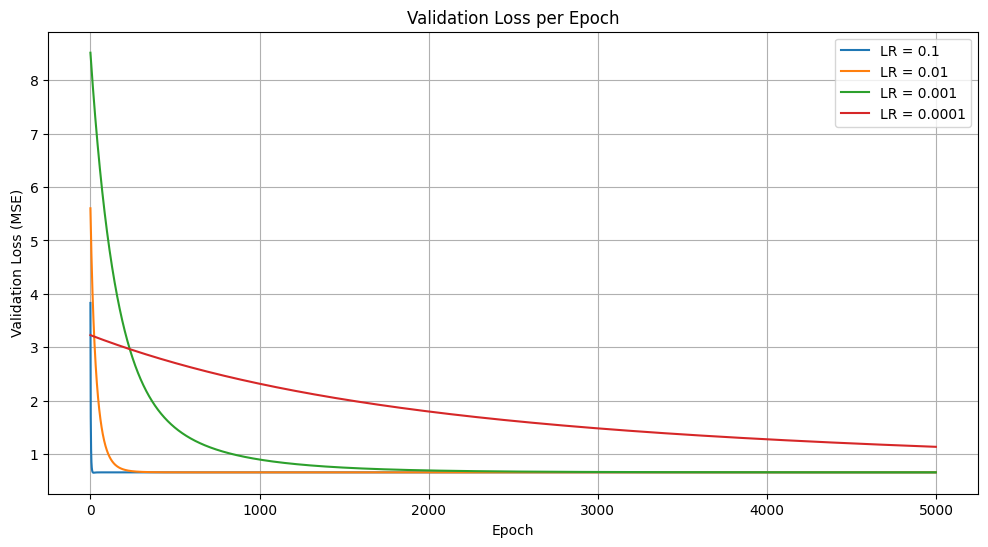

In [64]:
# Visualization

plt.figure(figsize=(12, 6))

for lr, results in all_results.items():
    # Plot validation loss
    plt.plot(results['val_loss'], label=f'LR = {lr}')

plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Problem 3:


In [65]:
# Baseline Linear Model
class Net_Linear(nn.Module):
    def __init__(self):
        super(Net_Linear, self).__init__()
        self.layer = nn.Linear(5, 1) # 5 inputs, 1 output

    def forward(self, x):
        return self.layer(x)

In [66]:
# Load data
df = pd.read_csv('/Housing.csv')

X_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
y_col = 'price'

X = df[X_cols].values
y = df[y_col].values.reshape(-1, 1)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# 80% train, 20% validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

In [67]:
def count_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, n_epochs, X_train, y_train, X_val, y_val, lr=0.01):
    """
    Trains a given nn.Module model.
    Returns a dictionary of results.
    """

    # Loss function (Mean Squared Error for regression)
    loss_fn = nn.MSELoss()

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print(f"--- Training {model.__class__.__name__} for {n_epochs} epochs ---")

    # History for plotting
    history_train_loss = []
    history_val_loss = []

    start_time = time.time()

    for epoch in range(1, n_epochs + 1):

        # Training
        model.train()
        y_pred_train = model(X_train)
        loss_train = loss_fn(y_pred_train, y_train)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val)
            loss_val = loss_fn(y_pred_val, y_val)

        # Store history
        history_train_loss.append(loss_train.item())
        history_val_loss.append(loss_val.item())

    end_time = time.time()
    total_time = end_time - start_time

    # Results
    final_train_loss = history_train_loss[-1]
    final_val_loss = history_val_loss[-1]

    print(f"Training Complete.")

    return {
        'model_name': model.__class__.__name__,
        'model_object': model,
        'train_time': total_time,
        'train_loss': final_train_loss,
        'val_loss': final_val_loss,
        'history_train': history_train_loss,
        'history_val': history_val_loss,
        'params': count_parameters(model)
    }

3.a Build a fully connected neural network for the housing dataset you did in previous problem. For training and validation use 80% (training) and 20% (validation) split. For this part, only use one hidden layer with 8 nodes. Train your network for 200 epochs. Report your training time, training loss, and evaluation accuracy after 200 epochs. Analyze your results in your report. Make sure to submit your code by providing the GitHub URL of your course repository for this course. (15pts)

In [68]:
class Net_1_Hidden(nn.Module):
    def __init__(self):
        super(Net_1_Hidden, self).__init__()
        # Input layer (5 features) to hidden layer (8 nodes)
        self.hidden = nn.Linear(5, 8)
        # Activation function
        self.activation = nn.ReLU()
        # Hidden layer (8 nodes) to output layer (1 node)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.output(x)
        return x

In [69]:
model_1_hidden = Net_1_Hidden()

# Training
results_1_hidden = train_model(
    model = model_1_hidden,
    n_epochs = 200,
    X_train = X_train_t,
    y_train = y_train_t,
    X_val = X_val_t,
    y_val = y_val_t
)

print("\n--- Problem 3.a Report ---")
print(f"Model: {results_1_hidden['model_name']}")
print(f"Trainable Parameters: {results_1_hidden['params']}")
print(f"Total Training Time: {results_1_hidden['train_time']:.4f} seconds")
print(f"Final Training Loss: {results_1_hidden['train_loss']:.4f}")
print(f"Final Validation Loss (Accuracy): {results_1_hidden['val_loss']:.4f}")

--- Training Net_1_Hidden for 200 epochs ---
Training Complete.

--- Problem 3.a Report ---
Model: Net_1_Hidden
Trainable Parameters: 57
Total Training Time: 0.1985 seconds
Final Training Loss: 0.3396
Final Validation Loss (Accuracy): 0.6365


3.b Extend your network with two more additional hidden layers, like the example we did in lecture. Train your network for 200 epochs. Report your training time, training loss, and evaluation accuracy after 200 epochs. Analyze your results in your report. Make sure to submit your code by providing the GitHub URL of your course repository for this course. Analyze your results in your report and compare your model size and accuracy over the baseline implementation in Problem1. a. Do you see any over-fitting? Make sure to submit your code by providing the GitHub URL of your course repository for this course. (25pts)

In [70]:
class Net_3_Hidden(nn.Module):
    def __init__(self):
        super(Net_3_Hidden, self).__init__()
        # 5 -> 8
        self.layer1 = nn.Linear(5, 8)
        self.act1 = nn.ReLU()
        # 8 -> 8
        self.layer2 = nn.Linear(8, 8)
        self.act2 = nn.ReLU()
        # 8 -> 8
        self.layer3 = nn.Linear(8, 8)
        self.act3 = nn.ReLU()
        # 8 -> 1
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.output(x)
        return x

In [71]:
print("--- Starting Problem 3.b ---")

model_3_hidden = Net_3_Hidden()

# Training
results_3_hidden = train_model(
    model = model_3_hidden,
    n_epochs = 200,
    X_train = X_train_t,
    y_train = y_train_t,
    X_val = X_val_t,
    y_val = y_val_t
)

print("\n--- Problem 3.b Report ---")
print(f"Model: {results_3_hidden['model_name']}")
print(f"Trainable Parameters: {results_3_hidden['params']}")
print(f"Total Training Time: {results_3_hidden['train_time']:.4f} seconds")
print(f"Final Training Loss: {results_3_hidden['train_loss']:.4f}")
print(f"Final Validation Loss (Accuracy): {results_3_hidden['val_loss']:.4f}")

--- Starting Problem 3.b ---
--- Training Net_3_Hidden for 200 epochs ---
Training Complete.

--- Problem 3.b Report ---
Model: Net_3_Hidden
Trainable Parameters: 201
Total Training Time: 0.3312 seconds
Final Training Loss: 0.2741
Final Validation Loss (Accuracy): 0.6505


In [72]:
print("--- Running Baseline Linear Model for Comparison ---")

model_linear = Net_Linear()

# Training
results_linear = train_model(
    model = model_linear,
    n_epochs = 200,
    X_train = X_train_t,
    y_train = y_train_t,
    X_val = X_val_t,
    y_val = y_val_t
)

--- Running Baseline Linear Model for Comparison ---
--- Training Net_Linear for 200 epochs ---
Training Complete.


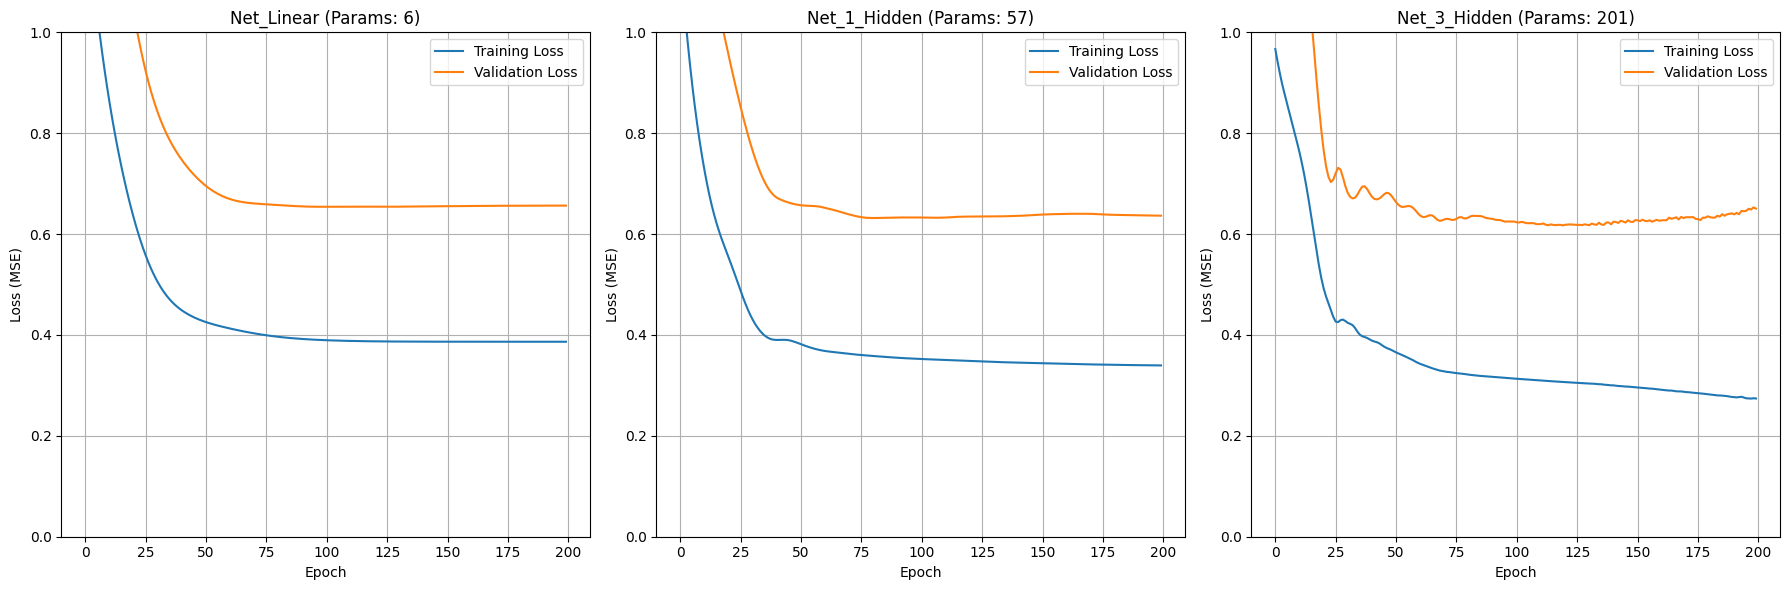

| Model | Trainable Parameters | Train Time (sec) | Final Train Loss | Final Validation Loss |
| Net_Linear (Baseline) | 6   | 0.14 | 0.3866 | 0.6565 |
| Net_1_Hidden (3.a)    | 57  | 0.20 | 0.3396 | 0.6365 |
| Net_3_Hidden (3.b)    | 201 | 0.33 | 0.2741 | 0.6505 |


In [80]:
all_results = [results_linear, results_1_hidden, results_3_hidden]

# Plot Loss Curves
plt.figure(figsize=(18, 6))

for i, res in enumerate(all_results):
    plt.subplot(1, 3, i + 1)
    plt.title(f"{res['model_name']} (Params: {res['params']})")
    plt.plot(res['history_train'], label='Training Loss')
    plt.plot(res['history_val'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Comparison
print("| Model | Trainable Parameters | Train Time (sec) | Final Train Loss | Final Validation Loss |")
print(f"| Net_Linear (Baseline) | {results_linear['params']}   | {results_linear['train_time']:.2f} | {results_linear['train_loss']:.4f} | {results_linear['val_loss']:.4f} |")
print(f"| Net_1_Hidden (3.a)    | {results_1_hidden['params']}  | {results_1_hidden['train_time']:.2f} | {results_1_hidden['train_loss']:.4f} | {results_1_hidden['val_loss']:.4f} |")
print(f"| Net_3_Hidden (3.b)    | {results_3_hidden['params']} | {results_3_hidden['train_time']:.2f} | {results_3_hidden['train_loss']:.4f} | {results_3_hidden['val_loss']:.4f} |")